In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_chroma langchain_core langchain_community chromadb pypdf fpdf

In [3]:
import sqlite3
import chromadb

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.graph import START, StateGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal

from langgraph.errors import NodeInterrupt
from datetime import datetime
from langchain_core.messages import AIMessage
from random import random

#connect to SQLite DB
conn = sqlite3.connect('hotel.db')
cursor = conn.cursor()

# Create the rooms table
cursor.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data = [
  (101, 'Single', 100, 1, 'TV, Wi-Fi'),
  (102, 'Double', 150, 2, 'TV, Wi-Fi, Balcony'),
  (103, 'Suite', 250, 3, 'TV, Wi-Fi, Balcony, Jacuzzi'),
  (104, 'Deluxe', 200, 2, 'TV, Wi-Fi, Mini-bar'),
  (105, 'Family Suite', 300, 4, 'TV, Wi-Fi, Balcony, Kitchenette'),
  (106, 'Executive Suite', 350, 2, 'TV, Wi-Fi, Balcony, Jacuzzi, City View'),
  (107, 'Double', 150, 2, 'TV, Wi-Fi'),
  (108, 'Deluxe', 200, 2, 'TV, Wi-Fi, Balcony, Fireplace')
]

# Insert the data
cursor.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data)

reservations_data = [
    ('Alice Smith', 102, '2025-03-15', '2025-03-18'),
    ('Bob Johnson', 105, '2025-04-22', '2025-04-25'),
    ('Charlie Brown', 106, '2025-06-10', '2025-06-12')
]

# Insert the data
cursor.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data)

conn.commit()
conn.close()
print("Database initialized successfully.")

# initialize the memory saver
memory = MemorySaver()

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)


# define our db as a set of sql tools
db = SQLDatabase.from_uri("sqlite:///hotel.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# write compliance rules to the file and read it back
with open('compliance.txt', 'w') as file:
    file.write('The system should refuse or redirect queries with:')
    file.write('Illegal requests (e.g., falsifying documents, fraudulent bookings).')
    file.write('Hate speech, harassment, or explicit threats toward individuals or groups.')
    file.write('Offensive, obscene, or otherwise harmful content.')
    file.write('Request of information about other guests. You cannot share there names or dates of stay')

with open('compliance.txt', 'r') as file:
    content = file.read()

# Set up OpenAI embeddings
embedding_function = OpenAIEmbeddingFunction(
    api_key=userdata.get('OPENAI_API_KEY'),
    model_name="text-embedding-ada-002"  # OpenAI's ada embeddings
)

# Initialize Chroma client with OpenAI embedding function
client = chromadb.Client()
collection = client.create_collection(
    name="compliance_rules",
    embedding_function=embedding_function
)

# Add documents to Chroma DB
collection.add(
    documents=[content],
    ids=["compliance_rules"]
)

print("VectorStore initialized successfully.")

# Set up OpenAI embeddings
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('OPENAI_API_KEY'))

# Connect LangChain with your Chroma collection
vectorstore = Chroma(
    client=client,
    collection_name="compliance_rules",
    embedding_function=openai_embeddings
)

# create a custom tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vectorstore.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

rag_tools = [retrieve]

print("VectorStore connected to LangGraph successfully.")

Database initialized successfully.
VectorStore initialized successfully.
VectorStore connected to LangGraph successfully.


In [4]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import logging

logger = logging.getLogger("Hotel Reservation MAS")
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s')
file_handler = logging.FileHandler('logs.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# bind LLM with tools
llm_with_sql_tools = llm.bind_tools(tools=sql_tools)
llm_with_rag_tools = llm.bind_tools(tools=rag_tools)


# System message for conversational agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system. Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or forward the conversation to the next agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Route the conversation if necessary: If the request requires expertise outside your scope, forward it to a specialized agent by answering with the name of the corresponding agent. There are the following agents available:

  - reservation_assistant;
  - compliance_checker.

  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for.

  Guidelines:

  - First you need to forward every query to compliance checker. If it violates any rule then do not respond, otherwise respond yourself or forward the query to the next agent.
  - For general inquiries (e.g., facilities, amenities, location details), assist the user directly.
  - If user wants to book a room. The following information: room type, required dates. Only if user has provided this information forward to the reservation_assistant otherwise do not mention reservation_assistant.
   """)

# System message for sql-based reservation agent
sys_msg_sql = SystemMessage(content="""

  You are AI assistant specialized in SQL. You have access to the following database schema:

  Table: rooms
    room_number (INTEGER PRIMARY KEY)
    room_type (TEXT NOT NULL)
    price (REAL NOT NULL)
    max_capacity (INTEGER NOT NULL)
    amenities (TEXT)

  Table: reservations
    reservation_id (INTEGER PRIMARY KEY AUTOINCREMENT)
    guest_name (TEXT NOT NULL)
    room_number (INTEGER NOT NULL, FOREIGN KEY REFERENCES rooms(room_number))
    start_date (DATE NOT NULL)
    end_date (DATE NOT NULL)

  You must:
    Provide SQL queries or instructions referencing only these two tables and the columns defined above.
    Generate valid SQL statements that accurately address the user’s questions or requests.
    Include explanations about how the queries work or how they address the request.
    Use best practices for SQL (proper joins, filters, etc.).
    Do not reference any tables or columns other than rooms and reservations.
    If the user’s request is unclear or not possible with the given schema, ask for clarification or note the limitations.
    If user want to book a room check if the room is not already booked for the corresponding dates

   """)

# System message for rag-based compliance checker
sys_msg_rag = SystemMessage(content=f"""

  You are the Compliance Checker agent. Your role is to:
  - Understand the user’s request and determine which rules, regulations, or guidelines are relevant to the query.
  - Search a vector database (embedding-based document retrieval) to find the most pertinent guidelines or regulations that must be checked.

      You have read-only access to this vector database containing short texts, summaries, or entire regulations.
      You can pass a query (the user’s question, plus any relevant context) to retrieve the top related guidelines or rules.
  - Synthesize the results of your vector DB retrieval to provide a clear compliance assessment or recommendation.
      If the user’s question is ambiguous, incomplete, or requires additional detail to ensure compliance, politely request clarification.
      If no relevant guidelines can be found, state that no matching guidelines are found and ask the user if they have additional info.
  - Never fabricate guidelines. Only cite or summarize what is actually found in the vector database. If you cannot find relevant information, say so.


  Please follow these steps when generating a response:
    - you should not try to answer the request you should just check if it is compliant.
    - Retrieve the relevant guidelines from the vector DB using the user’s question or text as the query.
    - Summarize or quote the most critical points from those guidelines.
    - Provide your compliance assessment, specifying:
      Which guidelines apply
    - If you cannot find any rules to apply it means that the request is compliant.

    \n\n
        {0}

   """)

from typing import Annotated, TypedDict, NotRequired, Dict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class StateWithSelfAssessment(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  confidence: int
  error: Exception | None


class NotSureException(Exception):
  pass

class LLMCallException(Exception):
  pass

class RetrievalException(Exception):
  pass

# Agent node
def conv_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
   """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
   messages = state["messages"]

   confidence = 82

   if confidence > 80:
    try:
      # raise LLMCallException("The original LLM model doesn't work")
      return {"messages": [llm.invoke([sys_msg_conversation] + messages)],
              "confidence": confidence,
              "error": None}
    except LLMCallException as e:
      return {"messages": add_messages(messages,
                                      AIMessage(content="There was an error")),
            "confidence": confidence,
            "error": e}
   else:
    try:
     raise NotSureException("Need human agent support!")
     return {"messages": [llm.invoke([sys_msg_conversation] + add_messages(messages,
                                                                           AIMessage(content="You are extremely unsure. Please apologize for that and ask user to repeate everything")))],
             "confidence": confidence,
              "error": None}
    except NotSureException as e:
     return {"messages": add_messages(messages,
                                      AIMessage(content="There was an error")),
            "confidence": confidence,
            "error": e}


# SQL Agent node
def sql_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   SQL Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
  messages = state["messages"]

  date_today = datetime.now().strftime("%Y-%m-%d")

  confidence = state["confidence"]

  date_check_sys_msg = SystemMessage(content=f"""If the current request is related to a reservation. Make sure that all the dates are not in the past.
  Today is {date_today}. Answer with the single digit 0 if there is any problem otherwise answer with the single digit 1.""")


  if " 0" in llm.invoke([date_check_sys_msg] + messages).content:
    return {"messages": [llm.invoke([sys_msg_sql] + messages + [AIMessage(content=f"The reservation is in past. Please provide the actual dates. The date today is {date_today}")])],
            "confidence": confidence,
              "error": None}

  else:
    return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)],
          "confidence": confidence,
              "error": None}

# RAG Agent node
def rag_assistant(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
  """
   RAG Assistant Agent

   Args:
     state (StateWithSelfAssessment): The current state of the conversation.

   Returns:
     StateWithSelfAssessment: The updated state of the conversation.
   """
  messages = state["messages"]
  confidence = state["confidence"]

  try:
    raise RetrievalException("Cannot retrieve the documents")
    return {"messages": [llm_with_rag_tools.invoke([sys_msg_rag] + messages)],
            "confidence": confidence,
              "error": None}
  except RetrievalException as e:
    return {"messages": add_messages(messages,
                                      AIMessage(content="There was an error")),
            "confidence": confidence,
            "error": e}


# Node for answers generation based on retrieved documents
def generate(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
    Node for answer generation based on retrieved documents.

    Args:
      state (StateWithSelfAssessment): The current state of the conversation.

    Returns:
      StateWithSelfAssessment: The updated state of the conversation.
    """
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Run
    response = llm.invoke([sys_msg_rag] + conversation_messages)
    confidence = state["confidence"]
    return {"messages": [response],
            "confidence": confidence,
              "error": None}

# Error Handler Node
def error_handler_node(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
      Node that handles errors.

      Args:
        state (StateWithSelfAssessment): The current state of the conversation.

      Returns:
        StateWithSelfAssessment: The updated state of the conversation.
    """
    print("There was an error. Routed to the error_handler")

    logger.error(f"""{str(state["error"])}. Please check the thread with id {thread_id}""")

    return state


def human_intervention_node(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
      Node for involving a human operator during critical errors

      Args:
        state (StateWithSelfAssessment): The current state of the conversation.

      Returns:
        StateWithSelfAssessment: The same state of the conversation propagated further.
    """
    # Logic for forming a request to a human
    # e.g. create a support ticket or notify a human agent


    # Return information to the user that the request has been transferred to an operator
    print("Forwarded to the human")
    return state

def alternative_model_node(state: StateWithSelfAssessment) -> StateWithSelfAssessment:
    """
      Node using an alternative model or API.

      Args:
        state (StateWithSelfAssessment): The current state of the conversation.

      Returns:
        StateWithSelfAssessment: The updated state of the conversation.
    """
    # For example if the primary LLM model is unavailable or returns an error

    alternative_llm = ChatOpenAI(model="gpt-4o", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)
    print("Alternative model used")
    return {"messages": [alternative_llm.invoke([sys_msg_conversation] + state["messages"])],
            "confidence": state["confidence"],
              "error": None}

from langgraph.types import Command

def degraded_functionality_node(state: StateWithSelfAssessment) -> Command[Literal["retriever"]]:
    """
      Node providing limited functionality.

      Args:
        state (StateWithSelfAssessment): The current state of the conversation.

      Returns:
        StateWithSelfAssessment: The updated state of the conversation.
    """
    # Use a simpler approach that is less likely to cause an error

    message = AIMessage("""The system should refuse or redirect queries with:
      Illegal requests (e.g., falsifying documents, fraudulent bookings
      Hate speech, harassment, or explicit threats toward individuals or groups
      Offensive, obscene, or otherwise harmful content
      Request of information about other guests. You cannot share there names or dates of stay""")

    print("Hard-coded document set was used as the vectorDB doesn't work")

    return Command(
        update={"messages": add_messages(state["messages"],message),
            "confidence": state["confidence"],
              "error": None},
        goto="retriever"
    )


def decision_router_node(state: StateWithSelfAssessment) -> Literal["alternative_model", "degraded_functionality_retrieval", "human_intervention"]:
    """
    Node for dynamically selecting a recovery strategy.

    Args:
      state (StateWithSelfAssessment): The current state of the conversation.

    Returns:
      str: The name of the next node.
    """

    if isinstance(state["error"], LLMCallException):
        return "alternative_model"
    elif isinstance(state["error"], RetrievalException):
        return "degraded_functionality_retrieval"
    else:
        return "human_intervention"

def choose_next_node(state: StateWithSelfAssessment) -> Literal["reservation_assistant", "compliance_checker", "error_handler", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (StateWithSelfAssessment): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]

  if ("error" in last_message.content):
    return "error_handler"
  elif ("reservation_assistant" in last_message.content) or ("reservation assistant" in last_message.content):
    return "reservation_assistant"
  elif ("compliance_checker" in last_message.content) or ("compliance checker" in last_message.content):
    return "compliance_checker"

  # Add Node Interrup for incompliant conversations
  elif (("violate" in last_message.content) or ("concern" in last_message.content)
  or ("illegal" in last_message.content) or ("manipultion" in last_message.content)):
    raise NodeInterrupt(
            f"Warning! The user request violates our policies. The conversation is forwarded to a human assistant for the investigation"
        )
  else:
    return "__end__"

def custom_tools_condition(state: StateWithSelfAssessment) -> Literal["rag_tools", "conv_assistant", "error_handler"]:
  """
    Custom condition for selecting tools. This condition is extended to forward errors to the error handler.

  Args:
    state (StateWithSelfAssessment): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]
  if ("error" in last_message.content):
    return "error_handler"
  elif hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
    return "rag_tools"
  else:
    return "conv_assistant"


# Graph
builder = StateGraph(StateWithSelfAssessment)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("compliance_checker", rag_assistant)
builder.add_node("retriever", generate)
builder.add_node("sql_tools", ToolNode(sql_tools))
builder.add_node("rag_tools", ToolNode(rag_tools))

builder.add_node("error_handler", error_handler_node)
builder.add_node("human_intervention", human_intervention_node)
builder.add_node("alternative_model", alternative_model_node)
builder.add_node("degraded_functionality_retrieval", degraded_functionality_node)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")
builder.add_conditional_edges(
    "conv_assistant",
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    choose_next_node, path_map=["reservation_assistant", "compliance_checker", "error_handler", "__end__"])
builder.add_conditional_edges("reservation_assistant", tools_condition, path_map={"tools": "sql_tools", "__end__": "__end__"})
builder.add_conditional_edges("compliance_checker", custom_tools_condition, path_map=["rag_tools", "conv_assistant", "error_handler"])
builder.add_edge("sql_tools", "reservation_assistant")
builder.add_edge("rag_tools", "retriever")
builder.add_edge("retriever", "conv_assistant")


builder.add_conditional_edges("error_handler", decision_router_node, path_map=["alternative_model", "degraded_functionality_retrieval", "human_intervention"])
builder.add_edge("human_intervention", "__end__")
builder.add_conditional_edges(
    "alternative_model", choose_next_node, path_map=["reservation_assistant", "compliance_checker", "error_handler", "__end__"])
react_graph_with_memory = builder.compile(checkpointer=memory)


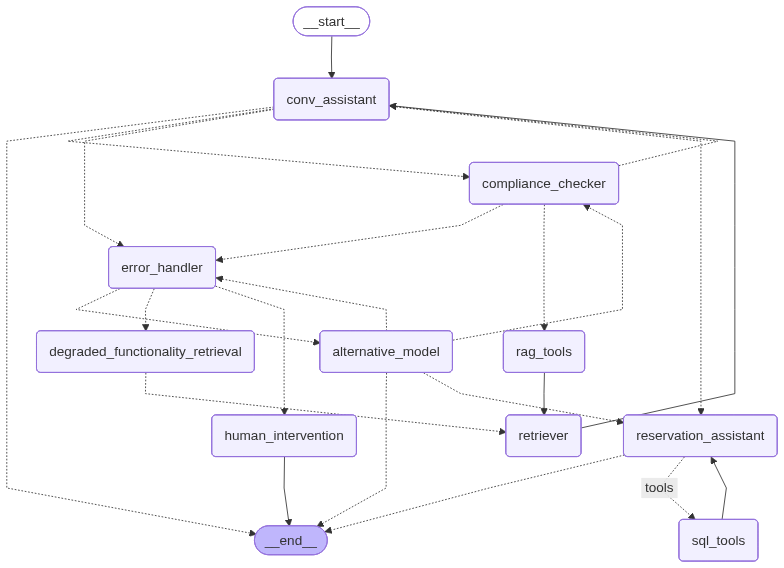

In [5]:
# Draw the graph
from IPython.display import Image, display
png = react_graph_with_memory.get_graph().draw_mermaid_png()
display(Image(png))

In [6]:
thread_id = 54  # Replace with the actual thread ID

# Example usage:
query = "Hey, I want to book a Family Suite 22.04.2025 till 25.04.2025"

events = react_graph_with_memory.stream({"messages": [HumanMessage(content=query)]},
                                        config={"thread_id": thread_id},  # Pass the thread_id here
                                        stream_mode="values")

# iterate over the messages
for event in events:
    event["messages"][-1].pretty_print()
    message_content = event["messages"][-1].content
    if "Answer:" in message_content:
        final_answer = message_content.split("Answer:", 1)[1].strip()

================================ Human Message =================================

Hey, I want to book a Family Suite 22.04.2025 till 25.04.2025


ERROR:Hotel Reservation MAS:Cannot retrieve the documents. Please check the thread with id 54


================================== Ai Message ==================================

Let me first check with our compliance checker to ensure everything is in order for your booking request. One moment, please. 

[Forwarding to compliance_checker]
================================== Ai Message ==================================

There was an error
There was an error. Routed to the error_handler
================================== Ai Message ==================================

There was an error
Hard-coded document set was used as the vectorDB doesn't work
================================== Ai Message ==================================

The system should refuse or redirect queries with:
      Illegal requests (e.g., falsifying documents, fraudulent bookings
      Hate speech, harassment, or explicit threats toward individuals or groups
      Offensive, obscene, or otherwise harmful content
      Request of information about other guests. You cannot share there names or dates of stay
========